In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
  

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('training/training_variants')
data_text = pd.read_csv('training/training_text',sep="\|\|",names=["ID","TEXT"],skiprows=1) 


In [ ]:
stop_words=set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        total_text=re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        data_text[column][index] = string

for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

In [3]:
#you need to run the above code
#dont run this lines of code
result=pd.read_pickle('pickle/copy/result')

In [4]:
result=pd.merge(data,data_text,on='ID',how='left')  

In [5]:
y_true=result['Class'].values
result.Gene=result.Gene.str.replace('\s+', '_')
result.Variation=result.Variation.str.replace('\s+', '_')

In [6]:
X_train,test_df,y_train,y_test=train_test_split(result,y_true,stratify=y_true,test_size=0.2)
train_df,cv_df,y_train,y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [8]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

variation_vectorizer=CountVectorizer()
train_variation_feature_onehotCoding=variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding=variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding=variation_vectorizer.transform(cv_df['Variation'])

text_vectorizer=CountVectorizer(min_df=3)
train_text_feature_onehotCoding=text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()

In [9]:
train_text_feature_onehotCoding=normalize(train_text_feature_onehotCoding,axis=0)
test_text_feature_onehotCoding=text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding=normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding=text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding=normalize(cv_text_feature_onehotCoding, axis=0)

In [10]:
train_gene_var_onehotCoding=hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding=hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding=hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding=hstack((train_gene_var_onehotCoding,train_text_feature_onehotCoding)).tocsr()
train_y=np.array(list(train_df['Class']))

test_x_onehotCoding=hstack((test_gene_var_onehotCoding,test_text_feature_onehotCoding)).tocsr()
test_y=np.array(list(test_df['Class']))

cv_x_onehotCoding=hstack((cv_gene_var_onehotCoding,cv_text_feature_onehotCoding)).tocsr()
cv_y=np.array(list(cv_df['Class']))

In [16]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 59905)
(number of data points * number of features) in test data =  (665, 59905)
(number of data points * number of features) in cross validation data = (532, 59905)


for alpha = 1e-05
Log Loss : 1.34692472251
for alpha = 0.0001
Log Loss : 1.33571186104
for alpha = 0.001
Log Loss : 1.33544842085
for alpha = 0.1
Log Loss : 1.31865850281
for alpha = 1
Log Loss : 1.31757676315
for alpha = 10
Log Loss : 1.37559137981
for alpha = 100
Log Loss : 1.44741286072
for alpha = 1000
Log Loss : 1.40497367937


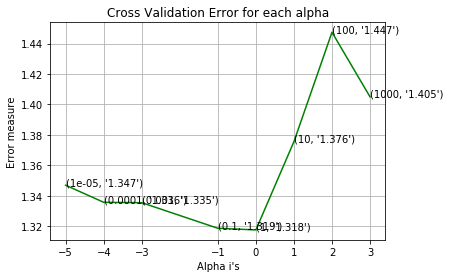

For values of best alpha =  1 The train log loss is: 0.916678188256
For values of best alpha =  1 The cross validation log loss is: 1.31757676315
For values of best alpha =  1 The test log loss is: 1.28693860488


In [11]:
alpha=[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array=[]
for i in alpha:
    print("for alpha =", i)
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(train_x_onehotCoding,train_y)
    sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss :",log_loss(cv_y,sig_clf_probs))
    
fig,ax=plt.subplots()
ax.plot(np.log10(alpha),cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha=np.argmin(cv_log_error_array)
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)


predict_y=sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
 

In [27]:
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)
sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y,sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

Log Loss : 1.31757676315
Number of missclassified point : 0.3890977443609023


In [26]:
test_point_index=166
no_feature=100
predicted_cls=sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.6111  0.0874  0.0221  0.1022  0.0497  0.0357  0.0821  0.0062  0.0034]]
Actual Class : 1
--------------------------------------------------
